In [1]:
import os
import glob
import warnings

import dask
from dask.distributed import Client
from dask import delayed, compute

import numpy as np
import xarray as xr
import dfm_tools as dfmt

/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from dask.distributed import Client

client = Client("tcp://145.136.59.51:45831")
client

<Client: 'tcp://145.136.59.51:45831' processes=32 threads=32, memory=32.00 GiB>

In [3]:
client.wait_for_workers(n_workers=32)

In [4]:
input_regex = r'/projects/0/einf1300/saltis-wp3-1/C_Work/05_RMD_2019/computations/D02/D02AU_newobs/RMD_dflowfm_D02AU_*_map.nc'

In [5]:
def check_file(file):
    file_name = file.split('/')[-1]
    try:
        test = xr.open_dataset(file)
        return None  # If the file is fine, return None
    except:
        warnings.warn(f'The file {file_name} seems to be corrupted. Check your inputs.', UserWarning)
        return file  # Return the file name if it's corrupted

def check_corrupted_files_parallel(input_regex):
    file_list = glob.glob(input_regex)

    # Create a list of delayed tasks
    tasks = [delayed(check_file)(file) for file in file_list]

    # Compute tasks in parallel
    results = compute(*tasks)

    # Filter out None values to get only corrupted files
    corrupted_files = [file for file in results if file is not None]

    return corrupted_files


In [9]:
%%time
corrupted_files = check_corrupted_files_parallel(input_regex)

CPU times: user 2.35 s, sys: 95.7 ms, total: 2.45 s
Wall time: 10min 17s


In [10]:
# I.x Check if there are any corrupted files in the listed files
if len(corrupted_files) > 0:
    print('There are corrupted files. These will be taken out of the file list for the next tests.')
    
# I.x Get the entire input list and remove the corrupted files
input_files = [f for f in glob.glob(input_regex) if not f in corrupted_files]

In [11]:
len(input_files)

96

In [12]:
%%time
ds = dfmt.open_partitioned_dataset(input_files, chunks={'time':1})

>> xu.open_dataset() with 96 partition(s): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 : 273.46 sec
>> xu.merge_partitions() with 96 partition(s): 17.11 sec
>> some variables dropped with merging of partitions: ['mesh2d_face_x_bnd', 'mesh2d_face_y_bnd']
>> dfmt.open_partitioned_dataset() total: 290.58 sec
CPU times: user 29.2 s, sys: 5.25 s, total: 34.5 s
Wall time: 4min 50s


In [13]:
times = ds.time
print(len(times))
gridname = ds.ugrid.grid.name
print(gridname)

793
mesh2d


In [14]:
ds

<xarray.Dataset> Size: 451GB
Dimensions:                      (time: 793, mesh2d_nNodes: 133336,
                                  mesh2d_nFaces: 126438, mesh2d_nLayers: 36,
                                  Two: 2, mesh2d_nInterfaces: 37,
                                  mesh2d_nEdges: 259786)
Coordinates:
  * time                         (time) datetime64[ns] 6kB 2019-07-30T12:00:0...
    mesh2d_node_x                (mesh2d_nNodes) float64 1MB dask.array<chunksize=(133336,), meta=np.ndarray>
    mesh2d_node_y                (mesh2d_nNodes) float64 1MB dask.array<chunksize=(133336,), meta=np.ndarray>
    mesh2d_face_y                (mesh2d_nFaces) float64 1MB dask.array<chunksize=(126438,), meta=np.ndarray>
    mesh2d_flowelem_zw           (time, mesh2d_nFaces, mesh2d_nInterfaces) float32 15GB dask.array<chunksize=(1, 126438, 37), meta=np.ndarray>
    mesh2d_flowelem_zcc          (time, mesh2d_nFaces, mesh2d_nLayers) float32 14GB dask.array<chunksize=(1, 126438, 36), meta=np.ndarray>
    mesh2d_face_x                (mesh2d_nFaces) float64 1MB dask.array<chunksize=(126438,), meta=np.ndarray>
    mesh2d_edge_x                (mesh2d_nEdges) float64 2MB dask.array<chunksize=(259786,), meta=np.ndarray>
    mesh2d_edge_y                (mesh2d_nEdges) float64 2MB dask.array<chunksize=(259786,), meta=np.ndarray>
  * mesh2d_nFaces                (mesh2d_nFaces) int64 1MB 0 1 ... 126436 126437
  * mesh2d_nEdges                (mesh2d_nEdges) int64 2MB 0 1 ... 259784 259785
  * mesh2d_nNodes                (mesh2d_nNodes) int64 1MB 0 1 ... 133334 133335
Dimensions without coordinates: mesh2d_nLayers, Two, mesh2d_nInterfaces
Data variables: (12/42)
    projected_coordinate_system  int32 4B ...
    timestep                     (time) float32 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    mesh2d_node_z                (mesh2d_nNodes) float64 1MB dask.array<chunksize=(133336,), meta=np.ndarray>
    mesh2d_tem1                  (time, mesh2d_nFaces, mesh2d_nLayers) float32 14GB dask.array<chunksize=(1, 126438, 36), meta=np.ndarray>
    mesh2d_ucz                   (time, mesh2d_nFaces, mesh2d_nLayers) float32 14GB dask.array<chunksize=(1, 126438, 36), meta=np.ndarray>
    mesh2d_taus                  (time, mesh2d_nFaces) float32 401MB dask.array<chunksize=(1, 126438), meta=np.ndarray>
    ...                           ...
    mesh2d_turkin1               (time, mesh2d_nEdges, mesh2d_nInterfaces) float32 30GB dask.array<chunksize=(1, 259786, 37), meta=np.ndarray>
    mesh2d_viu                   (time, mesh2d_nEdges, mesh2d_nLayers) float32 30GB dask.array<chunksize=(1, 259786, 36), meta=np.ndarray>
    mesh2d_flowlink_zu           (time, mesh2d_nEdges, mesh2d_nLayers) float32 30GB dask.array<chunksize=(1, 259786, 36), meta=np.ndarray>
    mesh2d_flowlink_zu_bnd       (time, mesh2d_nEdges, mesh2d_nLayers, Two) float32 59GB dask.array<chunksize=(1, 259786, 36, 2), meta=np.ndarray>
    mesh2d_edge_type             (mesh2d_nEdges) float64 2MB dask.array<chunksize=(259786,), meta=np.ndarray>
    mesh2d_windyu                (time, mesh2d_nEdges) float32 824MB dask.array<chunksize=(1, 259786), meta=np.ndarray>

In [15]:
# > Select only the relevant variables in the new for gradient computation /
# > salinity variance analysis. {gridname}_node_z is necessary to keep the
# > nodal dimension.
ds = ds[[f'{gridname}_node_z', f'{gridname}_sa1', 
f'{gridname}_ucx', f'{gridname}_ucy', f'{gridname}_ucz', f'{gridname}_tem1',
f'{gridname}_windx', f'{gridname}_windy', 
f'{gridname}_vicwwu', f'{gridname}_dtcell']]

In [16]:
ds

<xarray.Dataset> Size: 147GB
Dimensions:              (mesh2d_nNodes: 133336, time: 793,
                          mesh2d_nFaces: 126438, mesh2d_nLayers: 36,
                          mesh2d_nEdges: 259786, mesh2d_nInterfaces: 37)
Coordinates:
  * time                 (time) datetime64[ns] 6kB 2019-07-30T12:00:00 ... 20...
    mesh2d_node_x        (mesh2d_nNodes) float64 1MB dask.array<chunksize=(133336,), meta=np.ndarray>
    mesh2d_node_y        (mesh2d_nNodes) float64 1MB dask.array<chunksize=(133336,), meta=np.ndarray>
    mesh2d_face_y        (mesh2d_nFaces) float64 1MB dask.array<chunksize=(126438,), meta=np.ndarray>
    mesh2d_flowelem_zw   (time, mesh2d_nFaces, mesh2d_nInterfaces) float32 15GB dask.array<chunksize=(1, 126438, 37), meta=np.ndarray>
    mesh2d_flowelem_zcc  (time, mesh2d_nFaces, mesh2d_nLayers) float32 14GB dask.array<chunksize=(1, 126438, 36), meta=np.ndarray>
    mesh2d_face_x        (mesh2d_nFaces) float64 1MB dask.array<chunksize=(126438,), meta=np.ndarray>
    mesh2d_edge_x        (mesh2d_nEdges) float64 2MB dask.array<chunksize=(259786,), meta=np.ndarray>
    mesh2d_edge_y        (mesh2d_nEdges) float64 2MB dask.array<chunksize=(259786,), meta=np.ndarray>
  * mesh2d_nFaces        (mesh2d_nFaces) int64 1MB 0 1 2 ... 126436 126437
  * mesh2d_nEdges        (mesh2d_nEdges) int64 2MB 0 1 2 ... 259784 259785
  * mesh2d_nNodes        (mesh2d_nNodes) int64 1MB 0 1 2 ... 133334 133335
Dimensions without coordinates: mesh2d_nLayers, mesh2d_nInterfaces
Data variables:
    mesh2d_node_z        (mesh2d_nNodes) float64 1MB dask.array<chunksize=(133336,), meta=np.ndarray>
    mesh2d_sa1           (time, mesh2d_nFaces, mesh2d_nLayers) float32 14GB dask.array<chunksize=(1, 126438, 36), meta=np.ndarray>
    mesh2d_ucx           (time, mesh2d_nFaces, mesh2d_nLayers) float32 14GB dask.array<chunksize=(1, 126438, 36), meta=np.ndarray>
    mesh2d_ucy           (time, mesh2d_nFaces, mesh2d_nLayers) float32 14GB dask.array<chunksize=(1, 126438, 36), meta=np.ndarray>
    mesh2d_ucz           (time, mesh2d_nFaces, mesh2d_nLayers) float32 14GB dask.array<chunksize=(1, 126438, 36), meta=np.ndarray>
    mesh2d_tem1          (time, mesh2d_nFaces, mesh2d_nLayers) float32 14GB dask.array<chunksize=(1, 126438, 36), meta=np.ndarray>
    mesh2d_windx         (time, mesh2d_nFaces) float32 401MB dask.array<chunksize=(1, 126438), meta=np.ndarray>
    mesh2d_windy         (time, mesh2d_nFaces) float32 401MB dask.array<chunksize=(1, 126438), meta=np.ndarray>
    mesh2d_vicwwu        (time, mesh2d_nEdges, mesh2d_nInterfaces) float32 30GB dask.array<chunksize=(1, 259786, 37), meta=np.ndarray>
    mesh2d_dtcell        (time, mesh2d_nFaces, mesh2d_nLayers) float32 14GB dask.array<chunksize=(1, 126438, 36), meta=np.ndarray>

In [17]:
out_file = '~/smalloutfile.nc'

In [18]:
def write_file(ds, out_file):
    ds = ds
    out_file = out_file
    # Define counter for possible subdivision of times in writing
    i = 0
    for t in range(len(times)):

        # > Select the time
        print(f'Starting selection of timestep {t}...')
        tds = ds.isel(time=[t])
        #print(f'Loaded the dataset at timestep {t}.')

        if t == 0:
            # > For t = 0 in the range of timesteps, check if there's a file
            # > already present. If it is, remove it.
            if os.path.isfile(out_file):
                os.remove(out_file)

            # Use dask.delayed to write file to disk
            #print('Writing file to disk...')
            #print(f"Outputfile: {out_file}")
            write_task = dask.delayed(tds.ugrid.to_netcdf(out_file, mode='w'))

        else:
            # Use dask.delayed to write file to disk
            #print('Writing file to disk...')
            #print(f"Outputfile: {out_file}")
            write_task = dask.delayed(tds.ugrid.to_netcdf(out_file, mode='a'))

        write_task.compute()
        tds.close()

        # > Update counter
        i += 1

In [19]:
%%time
write_file(ds, out_file)

Starting selection of timestep 0...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 1...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 2...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 3...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 4...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 5...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 6...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 7...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 8...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 9...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 10...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 11...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 12...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 13...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 14...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 15...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 16...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 17...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 18...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 19...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 20...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 21...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 22...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 23...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 24...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 25...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 26...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 27...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 28...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.63 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 29...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 30...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 31...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 32...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 33...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 34...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 35...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 36...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 37...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 38...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 39...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 40...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 41...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 42...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 43...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 44...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 45...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 46...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.73 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 47...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 48...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 49...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 50...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 51...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 52...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 53...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 54...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 55...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 56...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 57...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 58...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 59...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.69 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 60...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 61...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 62...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 63...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 64...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 65...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 66...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 67...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 68...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 69...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 70...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 71...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 72...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 73...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 74...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 75...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 76...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 77...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 78...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 79...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 80...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 81...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 82...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 83...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 84...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 85...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 86...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 87...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 88...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 89...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 90...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 91...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 92...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 93...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 94...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 95...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 96...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.73 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 97...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 98...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 99...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 100...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 101...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 102...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 103...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 104...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 105...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 106...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 107...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 108...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 109...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 110...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 111...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 112...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 113...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 114...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 115...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 116...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 117...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 118...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 119...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 120...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 121...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 122...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 123...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 124...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 125...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 126...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 127...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 128...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 129...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 130...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 131...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 132...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 133...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 134...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 135...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 136...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 137...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 138...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 139...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 140...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 141...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 142...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 143...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 144...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 145...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 146...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 147...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 148...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 149...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 150...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 151...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 152...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 153...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 154...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 155...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 156...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 157...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 158...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 159...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 160...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 161...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.77 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 162...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 163...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 164...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 165...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 166...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 167...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 168...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 169...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 170...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 171...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 172...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 173...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 174...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 175...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 176...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 177...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 178...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 179...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 180...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 181...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 182...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 183...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 184...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 185...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 186...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 187...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 188...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 189...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 190...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 191...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 192...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 193...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 194...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 195...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 196...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 197...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 198...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 199...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 200...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 201...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 202...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 203...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 204...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 205...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 206...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 207...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 208...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 209...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 210...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 211...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 212...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 213...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 214...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 215...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 216...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 217...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 218...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 219...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 220...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 221...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 222...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 223...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 224...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 225...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 226...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 227...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 228...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 229...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 230...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.62 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 231...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 232...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 233...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 234...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 235...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 236...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 237...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 238...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 239...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 240...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 241...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 242...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 243...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 244...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 245...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 246...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 247...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 248...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 249...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 250...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 251...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 252...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 253...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 254...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 255...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 256...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 257...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 258...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 259...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 260...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 261...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 262...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 263...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 264...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 265...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 266...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 267...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 268...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 269...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 270...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 271...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 272...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.76 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 273...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 274...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 275...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 276...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 277...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 278...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.65 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 279...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 280...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 281...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 282...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 283...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 284...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 285...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 286...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 287...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 288...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 289...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 290...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 291...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 292...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 293...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 294...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 295...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 296...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 297...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 298...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 299...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 300...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 301...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 302...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 303...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 304...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 305...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 306...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 307...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 308...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 309...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 310...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 311...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 312...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 313...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 314...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 315...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.68 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 316...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 317...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 318...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 319...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 320...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 321...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 322...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 323...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 324...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 325...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 326...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 327...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 328...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 329...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 330...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 331...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 332...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 333...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.64 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 334...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 335...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 336...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 337...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 338...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 339...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 340...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 341...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 342...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 343...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 344...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 345...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 346...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 347...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 348...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 349...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 350...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 351...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 352...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 353...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 354...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 355...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 356...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 357...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 358...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 359...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 360...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 361...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 362...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 363...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 364...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 365...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 366...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 367...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 368...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 369...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 370...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 371...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 372...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 373...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 374...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 375...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 376...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 377...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 378...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 379...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 380...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 381...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 382...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 383...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 384...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 385...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 386...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 387...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 388...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 389...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 390...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 391...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 392...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 393...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 394...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 395...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 396...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 397...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 398...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 399...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 400...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 401...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 402...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 403...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 404...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 405...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 406...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 407...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 408...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 409...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 410...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 411...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 412...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 413...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 414...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 415...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 416...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.62 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 417...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 418...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 419...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 420...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 421...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 422...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 423...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 424...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 425...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 426...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 427...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 428...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 429...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 430...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 431...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 432...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 433...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 434...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 435...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 436...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 437...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 438...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 439...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 440...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 441...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 442...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 443...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 444...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 445...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 446...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 447...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 448...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 449...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 450...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 451...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 452...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 453...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 454...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 455...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 456...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 457...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 458...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 459...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 460...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 461...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 462...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 463...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 464...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 465...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 466...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 467...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 468...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 469...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 470...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 471...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.63 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 472...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 473...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 474...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 475...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 476...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 477...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 478...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 479...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 480...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 481...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 482...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 483...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 484...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 485...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 486...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 487...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 488...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 489...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 490...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 491...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 492...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 493...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 494...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 495...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 496...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.76 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 497...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 498...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 499...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 500...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 501...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 502...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 503...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 504...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 505...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 506...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 507...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 508...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 509...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 510...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 511...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 512...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 513...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 514...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 515...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 516...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 517...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 518...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 519...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 520...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 521...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.76 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 522...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 523...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 524...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 525...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.63 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 526...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.63 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 527...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 528...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 529...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.61 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 530...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 531...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 532...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 533...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 534...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 535...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 536...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 537...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 538...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 539...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 540...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 541...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 542...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 543...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 544...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 545...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 546...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 547...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 548...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.64 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 549...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 550...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 551...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 552...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 553...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 554...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 555...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 556...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 557...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 558...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 559...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 560...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 561...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 562...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 563...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 564...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 565...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 566...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 567...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.72 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 568...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 569...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 570...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 571...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 572...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 573...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 574...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 575...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 576...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 577...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 578...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 579...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 580...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.63 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 581...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 582...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 583...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 584...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 585...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 586...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 587...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 588...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 589...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 590...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 591...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 592...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 593...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 594...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 595...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 596...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 597...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 598...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 599...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 600...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 601...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 602...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 603...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 604...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 605...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 606...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.72 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 607...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 608...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 609...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 610...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 611...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 612...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 613...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 614...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 615...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 616...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 617...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 618...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 619...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 620...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 621...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 622...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 623...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 624...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 625...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 626...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 627...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 628...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 629...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 630...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 631...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 632...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 633...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 634...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 635...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 636...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 637...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 638...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.62 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 639...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 640...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 641...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 642...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 643...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 644...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 645...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 646...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 647...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 648...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 649...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.77 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 650...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 651...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 652...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 653...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 654...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 655...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 656...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 657...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 658...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 659...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 660...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 661...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 662...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 663...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.77 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 664...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 665...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 666...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 667...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 668...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 669...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 670...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 671...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 672...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 673...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 674...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 675...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 676...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 677...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 678...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 679...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 680...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 681...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 682...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 683...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 684...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 685...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 686...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 687...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 688...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 689...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 690...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 691...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 692...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 693...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 694...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 695...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 696...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 697...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 698...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 699...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 700...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 701...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 702...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 703...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 704...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 705...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 706...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 707...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 708...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 709...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 710...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 711...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 712...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 713...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 714...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 715...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 716...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 717...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 718...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 719...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 720...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 721...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 722...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.62 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 723...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 724...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 725...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 726...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 727...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 728...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 729...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 730...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 731...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 732...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 733...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 734...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 735...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 736...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 737...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 738...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 739...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 740...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 741...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 742...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 743...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 744...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 745...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.63 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 746...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 747...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 748...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 749...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 750...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 751...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 752...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 753...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 754...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 755...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 756...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 757...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 758...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 759...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 760...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 761...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 762...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 763...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 764...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 765...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 766...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 767...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 768...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 769...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 770...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 771...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 772...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 773...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 774...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 775...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 776...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 777...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 778...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 779...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 780...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 781...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 782...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 783...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 784...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 785...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 786...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 787...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 788...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 789...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 790...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 791...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Starting selection of timestep 792...


/home/rortiz/.conda/envs/jupyter_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 42.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 25min 27s, sys: 1min 3s, total: 26min 30s
Wall time: 1h 19min 43s


In [20]:
%%time
new_small_ds = xr.open_dataset(out_file)

CPU times: user 12.9 ms, sys: 3.98 ms, total: 16.8 ms
Wall time: 38.2 ms


In [21]:
new_small_ds

<xarray.Dataset> Size: 208MB
Dimensions:              (mesh2d_nFaces: 126438, mesh2d_nMax_face_nodes: 5,
                          mesh2d_nEdges: 259786, two: 2, mesh2d_nNodes: 133336,
                          time: 1, mesh2d_nLayers: 36, mesh2d_nInterfaces: 37)
Coordinates:
  * mesh2d_nFaces        (mesh2d_nFaces) int64 1MB 0 1 2 ... 126436 126437
  * mesh2d_nEdges        (mesh2d_nEdges) int64 2MB 0 1 2 ... 259784 259785
  * time                 (time) datetime64[ns] 8B 2019-09-01T12:00:00
    mesh2d_node_x        (mesh2d_nNodes) float64 1MB ...
    mesh2d_node_y        (mesh2d_nNodes) float64 1MB ...
    mesh2d_face_y        (mesh2d_nFaces) float64 1MB ...
    mesh2d_flowelem_zw   (time, mesh2d_nFaces, mesh2d_nInterfaces) float32 19MB ...
    mesh2d_flowelem_zcc  (time, mesh2d_nFaces, mesh2d_nLayers) float32 18MB ...
    mesh2d_face_x        (mesh2d_nFaces) float64 1MB ...
    mesh2d_edge_x        (mesh2d_nEdges) float64 2MB ...
    mesh2d_edge_y        (mesh2d_nEdges) float64 2MB ...
  * mesh2d_nNodes        (mesh2d_nNodes) int64 1MB 0 1 2 ... 133334 133335
Dimensions without coordinates: mesh2d_nMax_face_nodes, two, mesh2d_nLayers,
                                mesh2d_nInterfaces
Data variables: (12/13)
    mesh2d               int64 8B ...
    mesh2d_face_nodes    (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 5MB ...
    mesh2d_edge_nodes    (mesh2d_nEdges, two) float64 4MB ...
    mesh2d_node_z        (mesh2d_nNodes) float64 1MB ...
    mesh2d_sa1           (time, mesh2d_nFaces, mesh2d_nLayers) float32 18MB ...
    mesh2d_ucx           (time, mesh2d_nFaces, mesh2d_nLayers) float32 18MB ...
    ...                   ...
    mesh2d_ucz           (time, mesh2d_nFaces, mesh2d_nLayers) float32 18MB ...
    mesh2d_tem1          (time, mesh2d_nFaces, mesh2d_nLayers) float32 18MB ...
    mesh2d_windx         (time, mesh2d_nFaces) float32 506kB ...
    mesh2d_windy         (time, mesh2d_nFaces) float32 506kB ...
    mesh2d_vicwwu        (time, mesh2d_nEdges, mesh2d_nInterfaces) float32 38MB ...
    mesh2d_dtcell        (time, mesh2d_nFaces, mesh2d_nLayers) float32 18MB ...
Attributes:
    Conventions:  CF-1.9 UGRID-1.0

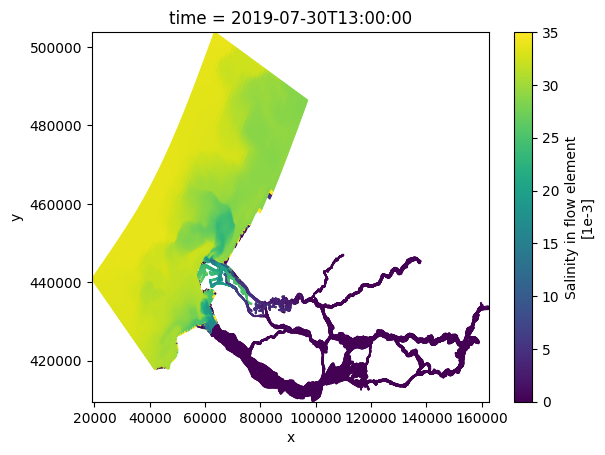

In [33]:
import xugrid as xu
#ds2 = xu.UgridDataset(ds)
ds.isel(time=1, mesh2d_nLayers=35)['mesh2d_sa1'].ugrid.plot()

In [38]:
import xugrid as xu
new_small_ds = xr.open_dataset(out_file)
#new_small_ds
#new_small_ds2 = xu.UgridDataset(new_small_ds)
new_small_ds.isel(time=1, mesh2d_nLayers=35)['mesh2d_sa1'].ugrid.plot()

IndexError: range object index out of range